### Prologue
Prepare the notebook for inline plotting<br>
Load require libraries<br>
Create custom functions<br>
Load and preprocess data<br>
Train a random forest using previously optimized/tuned hyper-parameters

In [1]:
from IPython.display import Image
%matplotlib inline
%run rf_analysis_utils.py

Utility code in the associated file performs the following steps:
defines function to print pretty confusion matrix: plot_confusion_matrix()
defines a function to get the class code by label: get_class_code()
defines a function to plot a tree inline: tree_to_code()
defines a function to extract all the structural arrays of a tree: get_tree_structure()
defines a function to extract a metrics dictionary from a random forest: explore_forest()
defines a function to pass batches of data to explore_forest(), split by correct/incorrect prediction: batch_analyse_model()
defines function to plot the mean path lengths from an object returned by explore_forest(): plot_mean_path_lengths()
defines a function to map the path of an instance down a tree: tree_path()
defines a function to map the path of an instance down a tree ensemble: forest_path()
defines a function to find the majority predicted class from object returned by forest_path(): major_class_from_forest_paths()
defines a function to conv

In [2]:
%run car_dataprep.py


M. Bohanec and V. Rajkovic: Knowledge acquisition and explanation for
multi-attribute decision making. In 8th Intl Workshop on Expert
Systems and their Applications, Avignon, France. pages 59-78, 1988.

Within machine-learning, this dataset was used for the evaluation
of HINT (Hierarchy INduction Tool), which was proved to be able to
completely reconstruct the original hierarchical model. This,
together with a comparison with C4.5, is presented in

B. Zupan, M. Bohanec, I. Bratko, J. Demsar: Machine learning by
function decomposition. ICML-97, Nashville, TN. 1997 (to appear)

Utility code in the associated file performs the following steps:
set random seed for the test_train_split
import packages and modules
defines a custom summary function: rstr()
create the list of variable names: var_names
create the list of features (var_names less class): features
import the car.csv file
create the pandas dataframe and prints head: car
create the categorical var encoder dictionary: le_dict
creat

The data objects are now saved and given a set of generic names ease of use.

In [3]:
# get the correct directory for saved objects
pickle_dir_store = open("pickle_dir.pickle", "rb")
pickle_dir = pickle.load(pickle_dir_store)
pickle_dir_store.close()

# helper function for pickling files
def pickle_path(filename):
    return(pickle_dir + '\\' + filename)

# load up the training set (required because of running from script into Jup Note)
encoder_store = open(pickle_path('encoder.pickle'), "rb")
encoder = pickle.load(encoder_store)
encoder_store.close()

X_train_enc_store = open(pickle_path('X_train_enc.pickle'), "rb")
X_train_enc = pickle.load(X_train_enc_store)
X_train_enc_store.close()

y_train_store = open(pickle_path('y_train.pickle'), "rb")
y_train = pickle.load(y_train_store)
y_train_store.close()


In [4]:
%run rf_analysis_modelprep.py

Parameter tuning (disabled)
Utility code in the associated file performs the following steps:
set random seed for the random forest
fetch the best parameters from model tuning results

Best OOB Cohen's Kappa during tuning: 0.9644
Best parameters: {'n_estimators': 1000, 'max_depth': 16, 'min_samples_leaf': 1}

Training a random forest model using best parameters... (please wait)

Done

Created helper function enc_model(). A pipeline: feature encoding -> rf model


### Random Forest Performance

Cohen's Kappa on unseen instances: 0.9588
Confusion matrix, without normalization
[[152   2]
 [  7 358]]
Normalized confusion matrix
[[0.99 0.01]
 [0.02 0.98]]


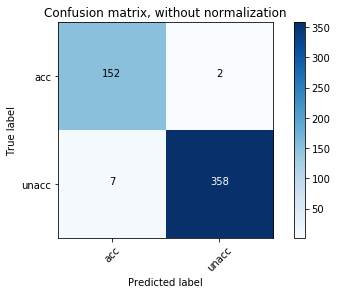

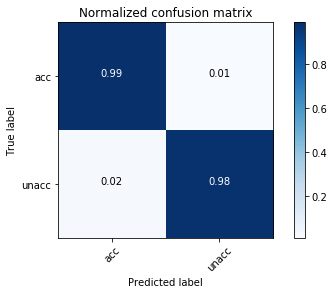

In [5]:
# test the model on unseen data
pred = enc_model.predict(X_test)
print("Cohen's Kappa on unseen instances: " "{:0.4f}".format(metrics.cohen_kappa_score(y_test, pred)))

# view the confusion matrix
cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.figure()
# normalized confusion matrix
plot_confusion_matrix(cm
                      , classes=class_names
                      , normalize=True,
                      title='Normalized confusion matrix')


# Analysis of Random Forests by Decision Paths and Votes
This code uses the sci-kit learn object model to analyse a large tree ensemble trained over the dataset.

Currently only non-weighted trees are supported, so that rules out Boosted models, but a future version is intended to support weighted trees (weighted voting). 

Currently only categorical data is supported, so that rules out ExtraTrees, but a future version is intended to support ExtraTrees (random threshold selection).

This method relies on the stochastic process that selects the best split node at each split from a randomly selected restricted subspace.

# Part 1. Global Explanations
## Statistical Analysis of a random forest model using data batches
* Inductive Properties are based on the training data
* Transductive Properties are based on the test (held out) data
* In both cases, the whole dataset is passed into the model and statistics are gathered about how frequently the features are visited.

* OOB data (to do)

In [6]:
# First instantiate new survey class with the RF model
f_survey = forest_surveyor(model = rf, features = onehot_features, prediction_model = enc_model)

In [7]:
########################################################################
### This takes a few minutes, so only run when an update is required ###
########################################################################

if True:
    '''
    batch = X_test
    labels = y_test

    correct_preds = enc_model.predict(batch) == labels
    incorrect_preds = enc_model.predict(batch) != labels
    
    if sum(correct_preds) > 0:
        X = batch[correct_preds.values]
        y = labels[correct_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_cor_stats = f_survey.forest_stats(np.unique(y))
        
    if sum(incorrect_preds) > 0:
        X = batch[incorrect_preds.values]
        y = labels[incorrect_preds.values]
        
        f_survey.fit(encoder.transform(X), y, onehot_features)
        f_incor_stats = f_survey.forest_stats(np.unique(y))
    
    tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "wb")
    pickle.dump(f_cor_stats, tt_correct_stats_store)
    tt_correct_stats_store.close()
    
    tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "wb")
    pickle.dump(f_incor_stats, tt_incorrect_stats_store)
    tt_incorrect_stats_store.close()
    '''

##### Load previously saved results

In [8]:
tt_correct_stats_store = open(pickle_path('tt_correct_stats.pickle'), "rb")
tt_correct_stats = pickle.load(tt_correct_stats_store)
tt_correct_stats_store.close()

tt_incorrect_stats_store = open(pickle_path('tt_incorrect_stats.pickle'), "rb")
tt_incorrect_stats = pickle.load(tt_incorrect_stats_store)
tt_incorrect_stats_store.close()

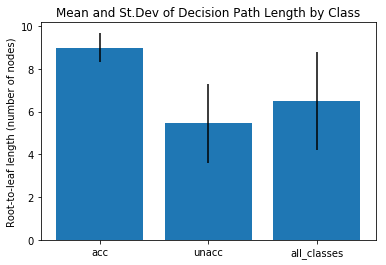

In [9]:
# comparing mean path lengths
plot_mean_path_lengths(tt_correct_stats, class_labels=class_names)

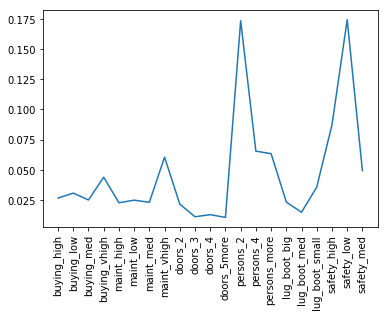

In [10]:
plt.plot(rf.feature_importances_)
plt.xticks(range(len(onehot_features)), onehot_features, rotation='vertical')
plt.show()

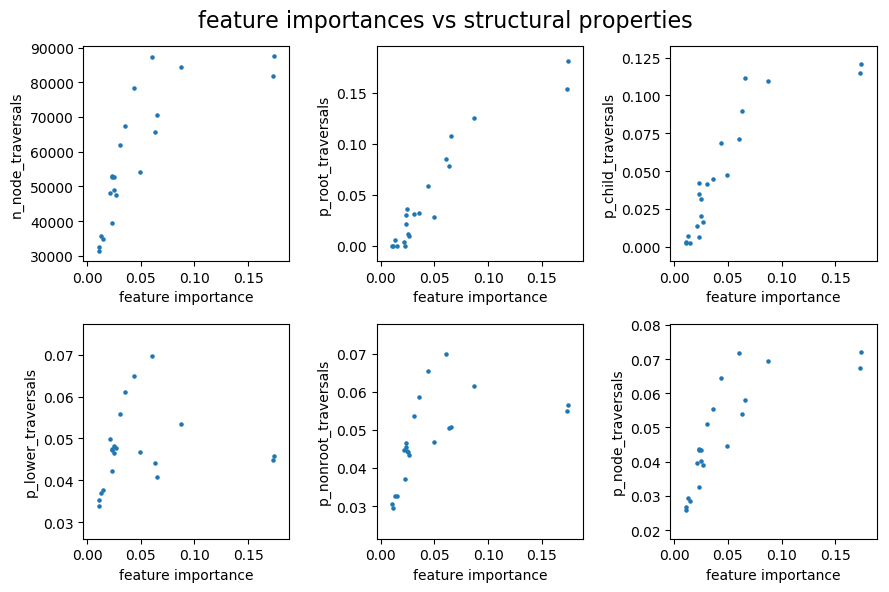

In [11]:
stat_impor_plot(importances = rf.feature_importances_, statistics = tt_correct_stats, label = 0)

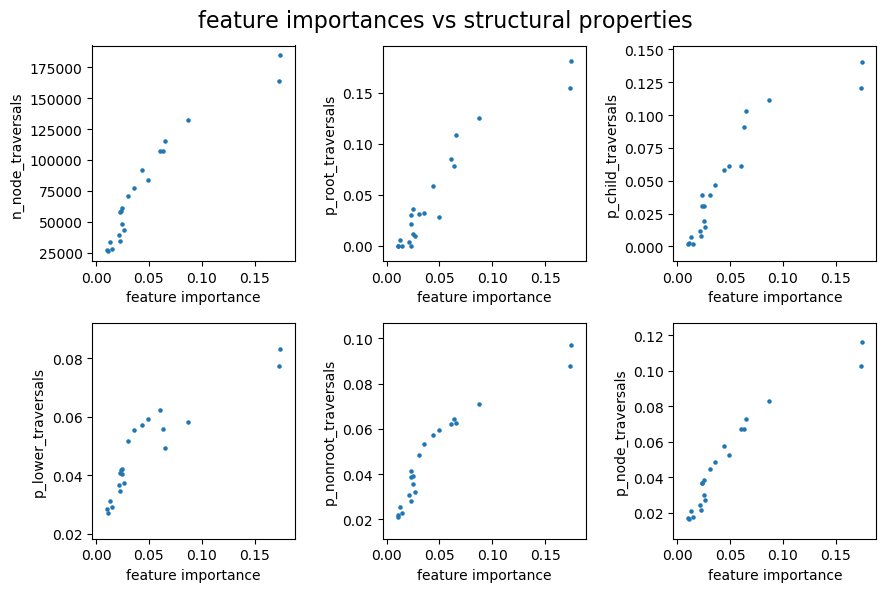

In [12]:
stat_impor_plot(importances = rf.feature_importances_, statistics = tt_correct_stats, label = 1)

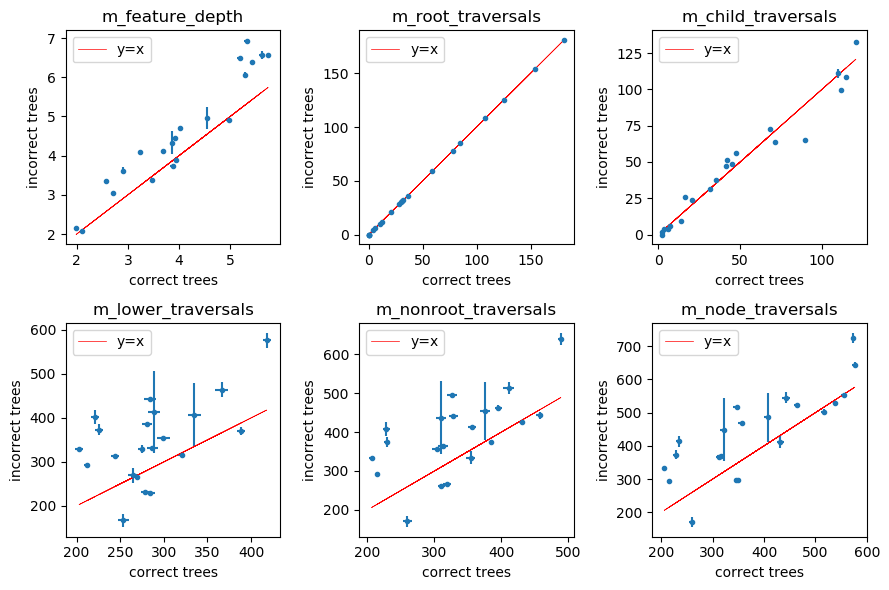

In [13]:
resids, rank = cor_incor_plot(cor = tt_correct_stats, incor = tt_incorrect_stats, label = 0)

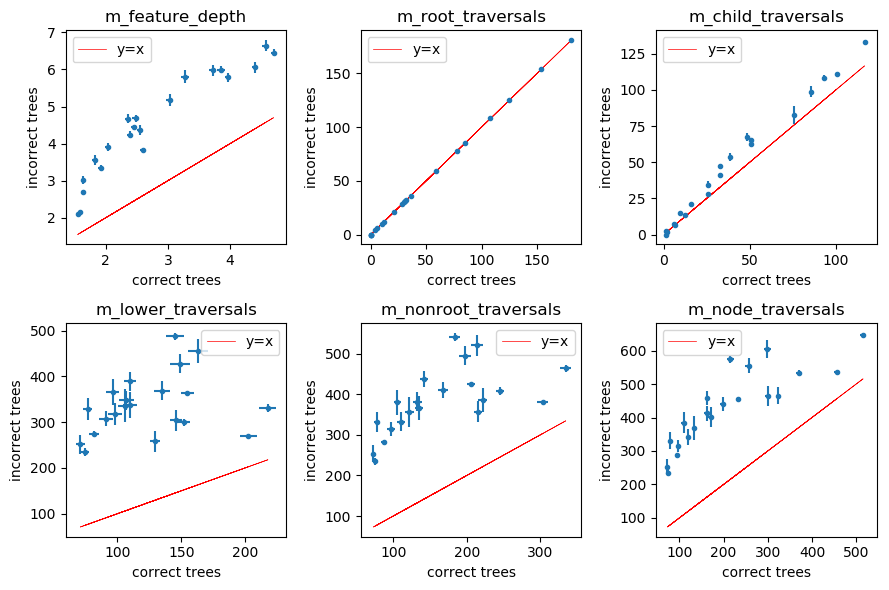

In [14]:
resids, rank = cor_incor_plot(cor = tt_correct_stats, incor = tt_incorrect_stats, label = 1)

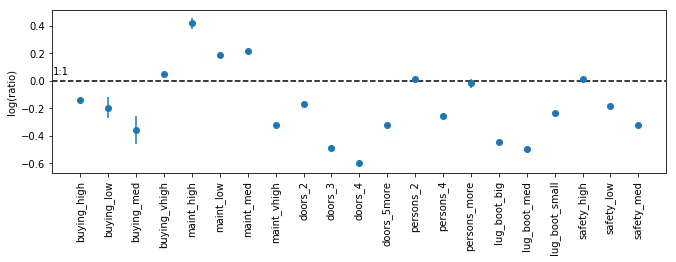

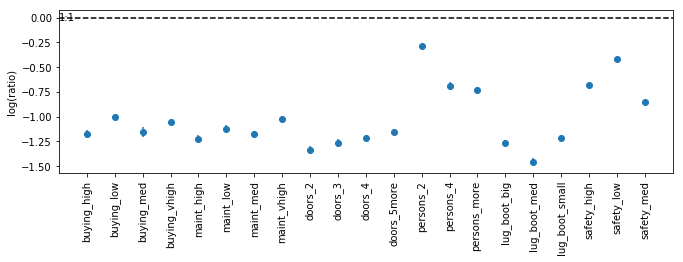

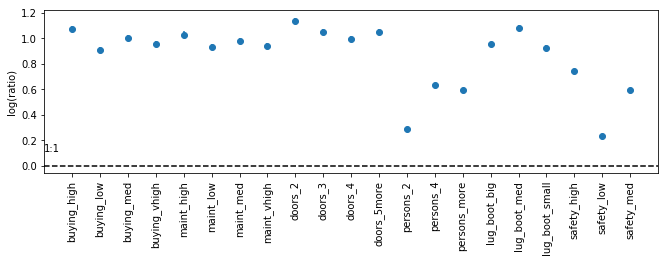

In [15]:
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_incorrect_stats[0]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[0]['se_lower_traversals']
                            , labels = onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[1]['m_lower_traversals']
                            , num_err = tt_correct_stats[1]['se_lower_traversals']
                            , denom = tt_incorrect_stats[1]['m_lower_traversals']
                            , denom_err = tt_incorrect_stats[1]['se_lower_traversals']
                            , labels = onehot_features
)
log_ratio = log_ratio_plot(num = tt_correct_stats[0]['m_lower_traversals']
                            , num_err = tt_correct_stats[0]['se_lower_traversals']
                            , denom = tt_correct_stats[1]['m_lower_traversals']
                            , denom_err = tt_correct_stats[1]['se_lower_traversals']
                            , labels = onehot_features
)

## Open Questions
There is a strong relationship between feature importance and feature depth, indicating that despite the randomness, feature importance exerts a pressure for a feature to be selected earlier.

Does it also mean a feature will be selected more frequently?

Is the relationship linear, or close to? Does feature depth add new information, compared to feature importance?
Feature depth is class specific. How can this be exploited?

Is this best suited to multi-class problems?

# Part 2. Local Explanations
## Analysis of decision paths for individual unseen instances in a random forest model
* Frequent Pattern Mining of decision paths
* Rule Compression of decision paths

In [16]:
first_n = 10

batch = X_test[0:first_n]
labels = y_test[0:first_n]

nfp = forest_path(forest = rf
                , feature_names = onehot_features
                , instances = batch
                , labels = None
                , feature_encoding = encoder
                , by_tree = False)

In [17]:
paths = {}
sorted_fp = {}
for instance in range(first_n):
    paths[instance] = get_paths(nfp, instance, by_tree = False, which_trees='majority')
    print('Instance ' + str(instance) + ':    True Class = ' + 
        str(labels[instance:instance+1].values[0]) + ' ' + 
          get_label(class_col, labels[instance:instance+1].values[0]) + 
        '    Majority voting trees = ' + str(len(paths[instance])))

Instance 0:    True Class = 0 acc    Majority voting trees = 982
Instance 1:    True Class = 1 unacc    Majority voting trees = 1000
Instance 2:    True Class = 1 unacc    Majority voting trees = 978
Instance 3:    True Class = 0 acc    Majority voting trees = 880
Instance 4:    True Class = 1 unacc    Majority voting trees = 956
Instance 5:    True Class = 1 unacc    Majority voting trees = 996
Instance 6:    True Class = 0 acc    Majority voting trees = 862
Instance 7:    True Class = 1 unacc    Majority voting trees = 988
Instance 8:    True Class = 0 acc    Majority voting trees = 973
Instance 9:    True Class = 1 unacc    Majority voting trees = 1000


C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future thi

In [18]:
instance = 3

# Collect useful data for instance
true_class = labels[instance:instance+1].values[0]
pred_probs = enc_model.predict_proba(batch[instance:instance + 1])[0]

# get the class codes produced by the model and the true class
true_class_code = get_label(class_col, true_class)

class_code_confs = np.argsort(pred_probs)[::-1] # descending order
pred_class_code = get_code(class_col, class_names[class_code_confs[0]])
second_class_code = get_code(class_col, class_names[class_code_confs[1]])

print('Test instance id: ' + str(instance))
print('True class: ' + str(true_class))
print('Pedicted Class Probabilities ')
for c, n, p in zip(class_names, range(len(class_names)), pred_probs):
    print(n, c, "{:0.4f}".format(p))

# Display instance row
car_id = batch[instance:instance + 1].index[0]
car[car_id:car_id + 1]

Test instance id: 3
True class: 0
Pedicted Class Probabilities 
0 acc 0.8800
1 unacc 0.1200


C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,buying,maint,doors,persons,lug_boot,safety,acceptability
671,high,med,2,more,med,high,acc


No frequent patterns longer than 2 items. Stopping early.
No frequent patterns longer than 2 items. Stopping early.


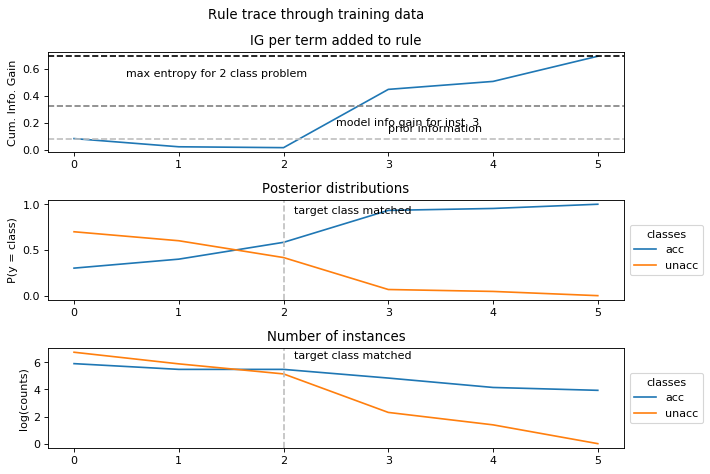

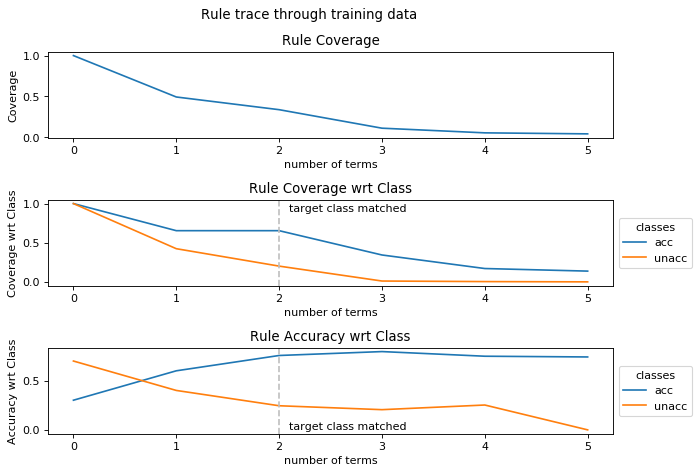

No frequent patterns longer than 2 items. Stopping early.


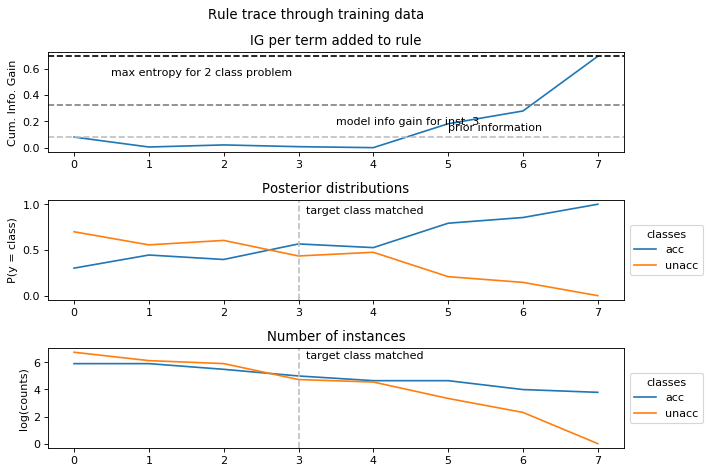

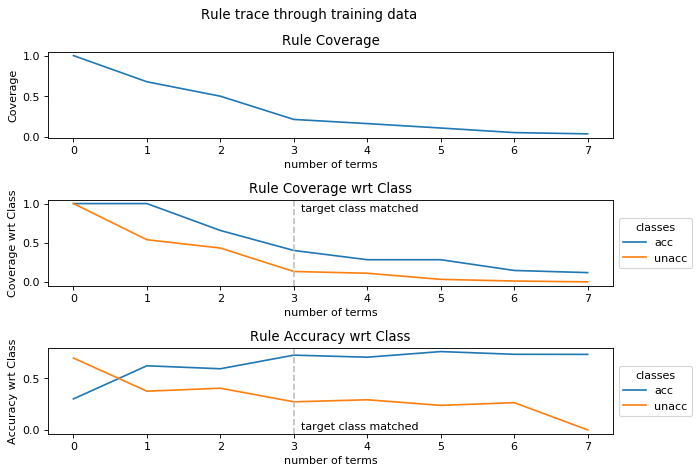

In [19]:
# training data - could be a representative sample if original tr is too large or unavailable
training_data = X_train
training_labels = y_train

# MAJORITY
# generate a set of paths, sorting can be tuned
sorted_fp = get_sorted_fp(get_paths(nfp, instance, by_tree = False, which_trees='majority'),
                                 support = 0.2, max_itemset_size = 6, alpha = 0.0)
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(get_paths(nfp, instance, by_tree = False, which_trees='minority'),
                                 support = 0.2, max_itemset_size = 6, alpha = 0.0)

# create the rule accumulator
ra = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp)

# run the profile
ra, model_votes = profile_instance(instance=instance
                                     , fp_object = nfp
                                     , rule_acc = ra
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 0.8)

# MINORITY
# generate a set of paths, sorting can be tuned
sorted_fp_min = get_sorted_fp(get_paths(nfp, instance, by_tree = False, which_trees='minority'),
                                 support = 0.2, max_itemset_size = 6, alpha = 0.0)

# create the rule accumulator
ra_min = rule_accumulator(vars_dict=vars_dict, onehot_dict = onehot_dict, rule_list=sorted_fp_min)

# run the profile
ra_min, model_votes = profile_instance(instance=instance
                                     , fp_object = nfp
                                     , rule_acc = ra_min
                                     , training_data = encoder.transform(training_data)
                                     , training_labels = training_labels
                                     , features = onehot_features
                                     , class_names = class_names
                                     , stopping_param = 0.8)

In [20]:
ra.rule

[('lug_boot_small', True, 0.5),
 ('maint_vhigh', True, 0.5),
 ('persons_2', True, 0.5),
 ('safety_high', False, 0.5),
 ('persons_more', False, 0.5),
 ('buying_vhigh', True, 0.5)]

In [21]:
ra.prune_rule()
ra.pruned_rule

[('lug_boot_small', True, 0.5),
 ('maint_vhigh', True, 0.5),
 ('safety_high', False, 0.5),
 ('persons_more', False, 0.5),
 ('buying_vhigh', True, 0.5)]

In [22]:
ra.tight_rule

[('safety_high', False, 0.5), ('persons_more', False, 0.5)]

In [23]:
p_count(training_labels.loc[apply_rule(ra.pruned_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([50], dtype=int64),
 'labels': array([0], dtype=int64),
 'p_counts': array([1.])}

In [24]:
p_count(training_labels.loc[apply_rule(ra.tight_rule, encoder.transform(training_data), onehot_features)].values)

{'counts': array([95, 33], dtype=int64),
 'labels': array([0, 1], dtype=int64),
 'p_counts': array([0.7421875, 0.2578125])}

In [25]:
p_count(training_labels.loc[apply_rule([
# ('lug_boot_small', True, 0.5),
# ('maint_vhigh', True, 0.5),
 ('safety_high', False, 0.5),
 ('persons_more', False, 0.5),
# ('buying_vhigh', True, 0.5)
], encoder.transform(training_data), onehot_features)].values)

{'counts': array([95, 33], dtype=int64),
 'labels': array([0, 1], dtype=int64),
 'p_counts': array([0.7421875, 0.2578125])}


## Open Questions
Frequent pattern mining must also be affected by number of trees and their diversity. Very variable solutions might generate many FP.

It appears likely to be necessary to test with the value of each feature in FP was actually true or false, in order to increase the significance of the pattern.

Support must play a key role in finding good quality information, but do we select the optimum? Does it relate to the tuning parameters of the model?

Would it make sense to try mining the frequent patterns of multiple instances of the same class (inductive/transductive mode)?

How important is ordering, as long as you have the same frequent patterns appearing? We could randomly switch the position of nodes and measure the performance difference.

# Part 3. Other Demos

## treeinterpreter - local explanations from conditional probabilities

In [26]:
from treeinterpreter import treeinterpreter as ti, utils
prediction, bias, contributions = ti.predict(rf, encoder.transform(batch[instance:instance + 1]))

interp_cols = sum([['predictor'], class_names, ['abseff']], [])
interp = pd.DataFrame(columns=interp_cols)
# now extract contributions for each instance
for c, feature in zip(contributions[0], onehot_features):
    if any(c != 0):
        vals = c.tolist()
        vals.insert(0, feature)
        vals.append(sum(abs(c)))
        interp = interp.append(dict(zip(interp_cols, vals))
                               , ignore_index=True)

In [27]:
interp = interp.sort_values('abseff', ascending=False).reset_index().drop('index', axis=1)
interp

,predictor,acc,unacc,abseff
0,safety_high,0.156578,-0.156578,0.313155
1,persons_2,0.135501,-0.135501,0.271001
2,safety_low,0.111733,-0.111733,0.223465
3,persons_more,0.102662,-0.102662,0.205325
4,maint_vhigh,0.082525,-0.082525,0.165051
5,maint_med,0.074057,-0.074057,0.148113
6,lug_boot_small,0.072094,-0.072094,0.144188
7,doors_2,-0.070948,0.070948,0.141895
8,persons_4,-0.043781,0.043781,0.087563
9,buying_vhigh,0.034793,-0.034793,0.069586


In [28]:
interp = interp.sort_values('acc', ascending=False).reset_index().drop('index', axis=1)
interp

,predictor,acc,unacc,abseff
0,safety_high,0.156578,-0.156578,0.313155
1,persons_2,0.135501,-0.135501,0.271001
2,safety_low,0.111733,-0.111733,0.223465
3,persons_more,0.102662,-0.102662,0.205325
4,maint_vhigh,0.082525,-0.082525,0.165051
5,maint_med,0.074057,-0.074057,0.148113
6,lug_boot_small,0.072094,-0.072094,0.144188
7,buying_vhigh,0.034793,-0.034793,0.069586
8,lug_boot_med,0.031589,-0.031589,0.063178
9,safety_med,0.009323,-0.009323,0.018647


In [29]:
priors = dict(zip(interp_cols[1:],  np.append(bias[0], 1.0)))
priors['predictor'] = 'priors (bias)'
totals = dict(zip(interp_cols[1:],  interp.sum()[1:].values))
totals['predictor'] = 'Total'
preds = dict(zip(interp_cols[1:],  np.append(prediction, 1.0)))
preds['predictor'] = 'P(class)'
interp_totals = pd.DataFrame(columns=interp_cols)
interp_totals = interp_totals.append(priors, ignore_index=True)

interp_totals = interp_totals.append(totals, ignore_index=True)
interp_totals = interp_totals.append(preds, ignore_index=True)
interp_totals

,predictor,acc,unacc,abseff
0,priors (bias),0.301322,0.698678,1.000000
1,Total,0.578678,-0.578678,2.101887
2,P(class),0.880000,0.120000,1.000000


## LIME

In [30]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

explainer = limtab.LimeTabularExplainer(training_data=np.array(X_train_enc.todense())
                                        , feature_names=onehot_features
                                        , training_labels=y_train
                                        , class_names=class_names
                                        , categorical_features=range(len(onehot_features))
                                        , categorical_names=onehot_features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

exp = explainer.explain_instance(np.array(encoder.transform(batch[instance:instance+1]).todense())[0]
                                 , rf.predict_proba
                                 , top_labels=4)

In [31]:
# basic setup
import lime
import lime.lime_tabular as limtab

np.random.seed(seed)

# Build the explainer from the training set
explainer = limtab.LimeTabularExplainer(training_data=training_data.as_matrix()
                                        , feature_names=features
                                        , training_labels=training_labels
                                        , class_names=class_names
                                        , categorical_features=categorical_features
                                        , categorical_names=features
                                        , mode='classification'
                                        , discretize_continuous=False
                                        , verbose=False)

# Explain test instance
exp = explainer.explain_instance(batch[instance:instance+1].as_matrix()[0]
                                 , enc_model.predict_proba
                                 , top_labels=4)

C:\Dev\Prog\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


[('safety=0', 0.3131946172656727),
 ('persons=2', 0.22658146269036467),
 ('maint=2', 0.09563339392967593),
 ('buying=0', -0.06120903950443479),
 ('doors=0', -0.05864320991090318),
 ('lug_boot=1', -0.002686783599462112)]

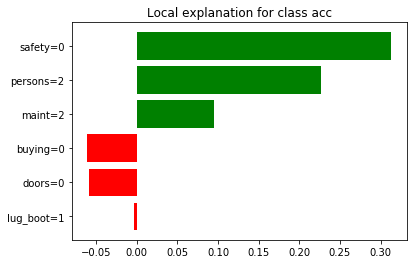

In [32]:
fig = exp.as_pyplot_figure(label=pred_class_code)
exp.as_list(label=pred_class_code)

[('safety=0', -0.3131946172656727),
 ('persons=2', -0.22658146269036467),
 ('maint=2', -0.09563339392967599),
 ('buying=0', 0.06120903950443482),
 ('doors=0', 0.058643209910903125),
 ('lug_boot=1', 0.0026867835994621473)]

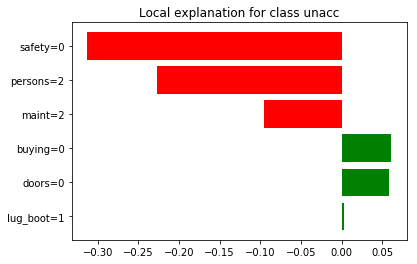

In [33]:
# Show the runner up class details
fig = exp.as_pyplot_figure(label=second_class_code)
exp.as_list(label=second_class_code)

In [34]:
exp.show_in_notebook()

In [35]:
import pyfpgrowth as fpg
patterns = fpg.find_frequent_patterns(paths_0, 200)
patterns

NameError: name 'paths_0' is not defined

In [ ]:
[i for i, (f, t) in enumerate(zip(var_names, vars_types)) if t == 'nominal' and vars_dict[f]['class_col'] == False]

In [ ]:
tt_correct_stats[3]['n_node_traversals']# - tt_incorrect_stats[3]['n_node_traversals']

In [ ]:
[f for _,f in sorted(zip(rank,onehot_features))]